# Predicting the Next Pandemic of Dengue
### Modeling Using FBProphet
by Brenda Hali

---
#### Importing Libraries

In [1]:
#data manipualtion libraries
import pandas as pd
import numpy as np
import seaborn as sns

#data visualization
from matplotlib import pyplot as plt

#data modeling libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

#FBProphet
from fbprophet import Prophet


#### Importing Datasets

In [2]:
sj_train = pd.read_csv('../1-Data/4-sj_train.csv')
iq_train = pd.read_csv('../1-Data/5-iq_train.csv')

sj_test = pd.read_csv('../1-Data/6-sj_test.csv')
iq_test = pd.read_csv('../1-Data/7-iq_test.csv')

In [3]:
sj_train.drop('Unnamed: 0', axis =1, inplace = True)
iq_train.drop('Unnamed: 0', axis =1, inplace = True)
sj_test.drop('Unnamed: 0', axis =1, inplace = True)
iq_test.drop('Unnamed: 0', axis =1, inplace = True)

In [4]:
sj_train.head()

,city,year,weekofyear,week_start_date,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,station_avg_temp_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.177617,12.42,297.572857,297.742857,292.414286,295.9,32.00,73.365714,12.42,14.012857,25.442857,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.155486,22.82,298.211429,298.442857,293.951429,296.4,17.94,77.368571,22.82,15.372857,26.714286,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.170843,34.54,298.781429,298.878571,295.434286,297.3,26.10,82.052857,34.54,16.848571,26.714286,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.235886,15.36,298.987143,299.228571,295.310000,297.0,13.90,80.337143,15.36,16.672857,27.471429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.247340,7.52,299.518571,299.664286,295.821429,297.5,12.20,80.460000,7.52,17.210000,28.942857,35.0,23.9,5.8,6


#### Pre-processing data to model

FBProphet just accept 2 values - The time value and the value to predict. We need to create a subset from the datasets from each city.

In [5]:
#creating a subset with the information needed - Total cases and weej start date. 
sj_train_fb = sj_train[['week_start_date', 'total_cases']] #sj subdataset
iq_train_fb = iq_train[['week_start_date', 'total_cases']] #iq subdataset

In [6]:
#data looks properly generated
iq_train_fb.tail()

,week_start_date,total_cases
515,2010-05-28,5
516,2010-06-04,8
517,2010-06-11,1
518,2010-06-18,1
519,2010-06-25,4


To use FBProphet is mandatory to name the time feature ds and the values to predict y.

In [7]:
sj_train_fb.columns, iq_train_fb.columns = ['ds', 'y'], ['ds', 'y']

#### Preparing the test data

In [8]:
sj_test_fb = sj_test[['week_start_date']]
iq_test_fb = iq_test[['week_start_date']]
#colum looks correct
sj_test_fb.head()

,week_start_date
0,2008-04-29
1,2008-05-06
2,2008-05-13
3,2008-05-20
4,2008-05-27


#### Modeling

In [9]:
def create_forecast(train_data, test_data, flex, seas):
    
    prophet = Prophet(changepoint_prior_scale=flex, 
                      yearly_seasonality=seas) 
    
    prophet.fit(train_data)
    
    future_frame = prophet.make_future_dataframe(
        periods=len(test_data), 
        freq='W')
    
    forecast = prophet.predict(future_frame)
    
    prophet.plot(forecast)
    
    forecast = forecast[['ds', 'yhat']].yhat\
        .apply(lambda x : int(x))
    
    return forecast[len(train_data):]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


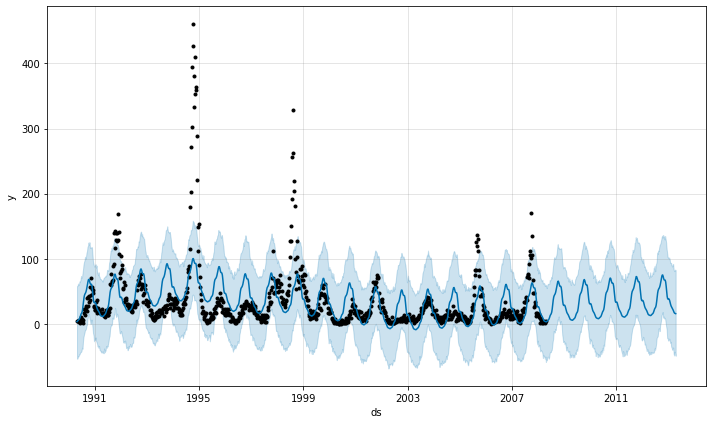

In [10]:
forecast_sj = create_forecast(
    sj_train_fb, sj_test_fb, 0.1, 10) #the first value refers to the Flexibility of the model, the second the seasonality

#### Forecasting in Iquitos

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


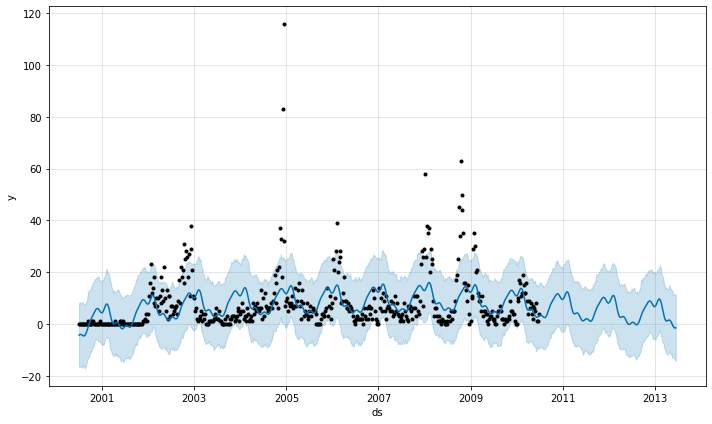

In [11]:
forecast_iq = create_forecast(
    iq_train_fb, iq_test_fb, 0.1, 5)

#### Saving results into the dataframe

In [12]:
# sj_predictions = sj_best_model.predict(sj_test).astype(int)
# iq_predictions = iq_best_model.predict(iq_test).astype(int)

In [13]:
sj_test_index = sj_test[['year', 'weekofyear']]

output = forecast_sj.reset_index().drop(['index'], axis=1)

output.columns = ['total_cases']

pd.concat([forecast_sj, output], axis=1);

In [14]:
#creating a new colum with MSE of our first predictions
sj_test['preds_fbprophet'] = forecast_sj
iq_test['preds_fbprophet'] = forecast_iq